In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
from glob import glob
import re
from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import pandas as pd
#from tqdm import tqdm
from scipy import stats
from sklearn.metrics import pairwise_distances

import utils.constants as constants
# from src.data import PhenoInfo, PhenoResults, get_all_tissues, get_genes
from data.multixcan_data import MXPhenoInfo, MXPhenoResults
from utils.utils import is_number, chunker

# Load metadata

In [3]:
with open(os.path.join(constants.PREPROCESSED_METADATA_DIR, 'genes_mapping_simplified-0.pkl'), 'rb') as f:
    genes_mapping_0 = pickle.load(f)

with open(os.path.join(constants.PREPROCESSED_METADATA_DIR, 'genes_mapping_simplified-1.pkl'), 'rb') as f:
    genes_mapping_1 = pickle.load(f)

# ClinVar data loading

In [4]:
clinvar_data = pd.read_csv(os.path.join(constants.DATA_DIR, 'clinvar/2019-07-16-gene_condition_source_id'), sep='\t')

In [5]:
display(clinvar_data.shape)
display(clinvar_data.head())

(11303, 9)

,#GeneID,AssociatedGenes,RelatedGenes,ConceptID,DiseaseName,SourceName,SourceID,DiseaseMIM,LastUpdated
0,2,A2M,NaN,C0002395,Alzheimer's disease,SNOMED CT,26929004,104300.0,16 Feb 2016
1,2,A2M,NaN,C3279661,Alpha-2-macroglobulin deficiency,NCBI curation,NaN,614036.0,16 Feb 2016
2,144568,A2ML1,NaN,C1833692,"Otitis media, susceptibility to",NCBI curation,NaN,166760.0,16 Feb 2016
3,53947,A4GALT,NaN,C3549485,p phenotype,SNOMED CT,24403008,111400.0,16 Feb 2016
4,8086,AAAS,NaN,C0271742,Glucocorticoid deficiency with achalasia,SNOMED CT,45414006,231550.0,16 Feb 2016


In [6]:
clinvar_data[clinvar_data['#GeneID'] == 144568]

,#GeneID,AssociatedGenes,RelatedGenes,ConceptID,DiseaseName,SourceName,SourceID,DiseaseMIM,LastUpdated
2,144568,A2ML1,NaN,C1833692,"Otitis media, susceptibility to",NCBI curation,NaN,166760.0,16 Feb 2016


In [7]:
unique_genes = clinvar_data['#GeneID'].unique()
display(len(unique_genes))

4194

In [8]:
clinvar_data['SourceName'].value_counts().head()

NCBI curation               3683
SNOMED CT                   2213
Office of Rare Diseases     1816
Human Phenotype Ontology     662
OMIM                         580
Name: SourceName, dtype: int64

## A look at the Alzheimer disease

In [25]:
clinvar_data[clinvar_data['DiseaseName'].str.lower().str.contains('alzheimer')]

,#GeneID,AssociatedGenes,RelatedGenes,ConceptID,DiseaseName,SourceName,SourceID,DiseaseMIM,LastUpdated
0,2,A2M,NaN,C0002395,Alzheimer's disease,SNOMED CT,26929004,104300.0,16 Feb 2016
42,10347,ABCA7,NaN,C4282179,"Alzheimer disease, type 9",NCBI curation,NaN,608907.0,16 Feb 2016
43,10347,NaN,ABCA7,C0002395,Alzheimer's disease,SNOMED CT,26929004,104300.0,16 Feb 2016
213,102,ADAM10,NaN,C3810041,Alzheimer disease 18,NCBI curation,NaN,615590.0,16 Feb 2016
586,348,APOE,NaN,C1847200,"Alzheimer disease, type 4",NCBI curation,NaN,606889.0,16 Feb 2016
587,348,APOE,NaN,C1863051,Alzheimer disease 2,NCBI curation,NaN,104310.0,02 Mar 2016
590,348,NaN,APOE,C0002395,Alzheimer's disease,SNOMED CT,26929004,104300.0,16 Feb 2016
595,348,NaN,APOE,CN043596,Early-Onset Familial Alzheimer Disease,GeneReviews,NBK1236,NaN,16 Feb 2016
596,348,NaN,APOE,CN043596,Early-Onset Familial Alzheimer Disease,GeneTests,21351,NaN,16 Feb 2016
597,348,NaN,APOE,CN043623,Late-Onset Familial Alzheimer Disease,GeneTests,21359,NaN,16 Feb 2016


# Prepare dataframe with gene associations

In [10]:
clinvar_non_empty_genes_data = clinvar_data.dropna(subset=['AssociatedGenes'])
display(clinvar_non_empty_genes_data.shape)

(7829, 9)

In [11]:
clinvar_unique_traits = pd.Index(clinvar_non_empty_genes_data['DiseaseName'].unique())
display(clinvar_unique_traits)

Index(['Alzheimer's disease', 'Alpha-2-macroglobulin deficiency',
       'Otitis media, susceptibility to', 'p phenotype',
       'Glucocorticoid deficiency with achalasia',
       'Keratosis palmoplantaris papulosa',
       'Charcot-Marie-Tooth disease, type 2N',
       'Epileptic encephalopathy, early infantile, 29',
       'Combined oxidative phosphorylation deficiency 8',
       'Leukoencephalopathy, progressive, with ovarian failure',
       ...
       'Myopia 21, autosomal dominant', 'Paget disease of bone 6',
       'ZNF711-Related X-linked Mental Retardation',
       'Seborrhea-like dermatitis with psoriasiform elements', 'PEHO syndrome',
       'Oocyte maturation defect 1', 'OOCYTE MATURATION DEFECT 6',
       'OOCYTE MATURATION DEFECT 3', 'Acromelic frontonasal dysostosis',
       'NEURODEVELOPMENTAL DISORDER WITH MOVEMENT ABNORMALITIES, ABNORMAL GAIT, AND AUTISTIC FEATURES'],
      dtype='object', length=5586)

In [12]:
# clinvar unique genes
clinvar_unique_genes = pd.Index(clinvar_non_empty_genes_data['AssociatedGenes'].unique())
display(clinvar_unique_genes)

Index(['A2M', 'A2ML1', 'A4GALT', 'AAAS', 'AAGAB', 'AARS', 'AARS2', 'AASS',
       'ABAT', 'ABCA1',
       ...
       'ZNF513', 'ZNF644', 'ZNF687', 'ZNF711', 'ZNF750', 'ZNHIT3', 'ZP1',
       'ZP2', 'ZP3', 'ZSWIM6'],
      dtype='object', length=4194)

In [13]:
clinvar_genes_associations = pd.DataFrame(index=clinvar_unique_genes, columns=clinvar_unique_traits, data=0, dtype='uint8')

In [14]:
display(clinvar_genes_associations.shape)
display(clinvar_genes_associations.head())

(4194, 5586)

,Alzheimer's disease,Alpha-2-macroglobulin deficiency,"Otitis media, susceptibility to",p phenotype,Glucocorticoid deficiency with achalasia,Keratosis palmoplantaris papulosa,"Charcot-Marie-Tooth disease, type 2N","Epileptic encephalopathy, early infantile, 29",Combined oxidative phosphorylation deficiency 8,"Leukoencephalopathy, progressive, with ovarian failure",...,"Myopia 21, autosomal dominant",Paget disease of bone 6,ZNF711-Related X-linked Mental Retardation,Seborrhea-like dermatitis with psoriasiform elements,PEHO syndrome,Oocyte maturation defect 1,OOCYTE MATURATION DEFECT 6,OOCYTE MATURATION DEFECT 3,Acromelic frontonasal dysostosis,"NEURODEVELOPMENTAL DISORDER WITH MOVEMENT ABNORMALITIES, ABNORMAL GAIT, AND AUTISTIC FEATURES"
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A4GALT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAGAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
for disease_name, disease_data in clinvar_non_empty_genes_data.groupby('DiseaseName'):
    common_genes = disease_data['AssociatedGenes'].unique()
    clinvar_genes_associations.loc[common_genes, disease_name] = 1

In [16]:
display(clinvar_genes_associations.shape)
display(clinvar_genes_associations.head())

(4194, 5586)

,Alzheimer's disease,Alpha-2-macroglobulin deficiency,"Otitis media, susceptibility to",p phenotype,Glucocorticoid deficiency with achalasia,Keratosis palmoplantaris papulosa,"Charcot-Marie-Tooth disease, type 2N","Epileptic encephalopathy, early infantile, 29",Combined oxidative phosphorylation deficiency 8,"Leukoencephalopathy, progressive, with ovarian failure",...,"Myopia 21, autosomal dominant",Paget disease of bone 6,ZNF711-Related X-linked Mental Retardation,Seborrhea-like dermatitis with psoriasiform elements,PEHO syndrome,Oocyte maturation defect 1,OOCYTE MATURATION DEFECT 6,OOCYTE MATURATION DEFECT 3,Acromelic frontonasal dysostosis,"NEURODEVELOPMENTAL DISORDER WITH MOVEMENT ABNORMALITIES, ABNORMAL GAIT, AND AUTISTIC FEATURES"
A2M,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A4GALT,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAS,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAGAB,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
assert clinvar_genes_associations.isna().sum().sum() == 0

In [23]:
# some testing
clinvar_genes_associations["Alzheimer's disease"].sort_values(ascending=False).head(10)

A2M      1
APP      1
MPO      1
NOS3     1
PLAU     1
HFE      1
FOXN1    0
FOXO1    0
FTSJ1    0
FTO      0
Name: Alzheimer's disease, dtype: int64

In [24]:
clinvar_genes_associations.sum().sort_values(ascending=False).head()

Diabetes mellitus type 2          28
Primary dilated cardiomyopathy    27
Familial cancer of breast         23
Mitochondrial diseases            21
Acute myeloid leukemia            20
dtype: int64

In [26]:
# define filename
genes_associations_dir = os.path.join(constants.PREPROCESSED_BASED_DIR, 'gene_associations')
clinvar_genes_associations_filename = os.path.join(genes_associations_dir, 'clinvar-gene_associations.pkl.xz')
display(clinvar_genes_associations_filename)

'/mnt/phenomexcan/results/preprocessed_data/gene_associations/clinvar-gene_associations.pkl.xz'

In [27]:
clinvar_genes_associations.index.rename('gene', inplace=True)

In [28]:
os.makedirs(genes_associations_dir, exist_ok=True)

clinvar_genes_associations.astype('uint8').to_pickle(clinvar_genes_associations_filename)

In [29]:
# load and test again the same stats as above
clinvar_genes_associations = pd.read_pickle(clinvar_genes_associations_filename)

In [30]:
clinvar_genes_associations.memory_usage().head()

Index                               33552
Alzheimer's disease                  4194
Alpha-2-macroglobulin deficiency     4194
Otitis media, susceptibility to      4194
p phenotype                          4194
dtype: int64

## Distribution of number of genes per trait

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
clinvar_traits_n_genes = clinvar_genes_associations.sum()
display(clinvar_traits_n_genes.shape)
display(clinvar_traits_n_genes.sort_values(ascending=False).head())

(5586,)

Diabetes mellitus type 2          28
Primary dilated cardiomyopathy    27
Familial cancer of breast         23
Mitochondrial diseases            21
Acute myeloid leukemia            20
dtype: int64

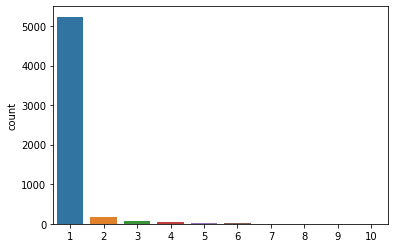

In [33]:
sns.countplot(clinvar_traits_n_genes[clinvar_traits_n_genes <= 10])

# Export to CSV

In [34]:
export_path = os.path.join(constants.PREPROCESSED_BASED_DIR, 'clinvar_data.tsv.gz')
display(export_path)

clinvar_genes_associations.to_csv(export_path, sep='\t')

'/mnt/phenomexcan/results/preprocessed_data/clinvar_data.tsv.gz'